#### Algorithm 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
import scipy.io

from keras.datasets import mnist

sns.set_theme()

In [2]:
def construct_tensor(A_train, D_train, k):
    
    makszn = (D_train[0]== np.bincount(D_train[0]).argmax()).sum()
    
    T = np.zeros((A_train.shape[0],makszn,k))

    for i in range(k):    
        for j in range(makszn):       
            if(j >= len(np.where(D_train==i)[1])):
                mjesto = np.random.randint(0, len(np.where(D_train==i)[1])-1)           
                T[:,j,i]=A_train[:, np.where(D_train == i)[1]][:,mjesto]
        
            else:
                T[:,j,i]=A_train[:, np.where(D_train == i)[1]][:,j]
    
    return(T)

In [3]:
def multiplication(T, M, mode): 
    
    descriptor = list(T.shape)
    descriptor[mode] = M.shape[0]
    pom = tl.unfold(T, mode)
    
    return (tl.fold( M @ pom, mode, descriptor))   

In [4]:
def HOSVD(T, p, q): 
    
    U1, _, _ = np.linalg.svd(tl.unfold(T, 0), full_matrices=False)
    U2, _, _ = np.linalg.svd(tl.unfold(T, 1), full_matrices=False)
    
    F_ = multiplication(T, np.transpose(U1[:, 0:p]), 0)
    F = multiplication(F_, np.transpose(U2[:, 0:q]), 1)
    
    return F, U1[:, 0:p]

In [5]:
def alg2_train(F, k, l):
    
    B = np.zeros((F.shape[0], l, k))
    
    for mi in range(F.shape[2]):
        U, _, _ = np.linalg.svd(F[:, :, mi], full_matrices=False)
        B[:, :, mi] = U[:, 0:l]
        
    return(B)

In [6]:
def alg2_test(A_test, B, U_p):
    
    digits = []
    
    for j in range(A_test.shape[1]): 
        
        d = A_test[:, j]
        d = np.transpose(U_p) @ d 
        
        r_min =  np.Inf
        
        for k in range(B.shape[2]): 

            r = np.linalg.norm(d - (B[:,:,k] @ (np.transpose(B[:,:, k]) @ d)))
            
            if(r < r_min):
                r_min = r 
                digit = k
                
        digits.append(digit)

    return digits 

#### Application of the algorithm for the MNIST digits

In [7]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_y = np.transpose(np.reshape(train_y, (60000,1)))
test_y = np.transpose(np.reshape(test_y, (10000,1)))

In [8]:
A_train = np.empty([train_X.shape[1] ** 2, train_X.shape[0]])

for i in range(train_X.shape[0]):
    A_train[:,i] = np.reshape(train_X[i],(28*28,)) 
    
D_train = train_y

A_test = np.empty([test_X.shape[1] ** 2, test_X.shape[0]])

for i in range(test_X.shape[0]):
    A_test[:,i] = np.reshape(test_X[i],(test_X.shape[1]**2,))
    
D_test = test_y

k = np.unique(D_train).size

p = 250

q = 100

In [49]:
T = construct_tensor(A_train[:, :5000], D_train[:, :5000], k)

F, U_p = HOSVD(T, p, q) 

B = alg2_train(F,k)

predictions = alg2_test(A_test, B, U_p)

np.count_nonzero(predictions == D_test[0]) / len(D_test[0])

0.9378

In [7]:
mat = scipy.io.loadmat('azip.mat')
A_train = mat['azip'] 
mat = scipy.io.loadmat('dzip.mat')
D_train = mat['dzip'] 

mat = scipy.io.loadmat('atest.mat')
A_test = mat['testzip'] 
mat = scipy.io.loadmat('dtest.mat')
D_test = mat['dtest'] 

k = np.unique(D_train).size

In [8]:
T = construct_tensor(A_train, D_train, k)

F, U_p = HOSVD(T, 64, 64) 

B = alg2_train(F,k,30)

predictions = alg2_test(A_test, B, U_p)

np.count_nonzero(predictions == D_test[0]) / len(D_test[0])

0.9252615844544095

In [88]:
mojalista1 = list()
mojalista2 = list()
mojalista3 = list()

p_list = np.array((32,64,64))
q_list = np.array((32,48, 64))
l_list = np.array(range(4,17))

T = construct_tensor(A_train, D_train, k)

for i in range(p_list.shape[0]): 
    
    for j in l_list:
    
        F, U_p = HOSVD(T, p_list[i], q_list[i]) 
        B = alg2_train(F, k, j)
    
        predictions = alg2_test(A_test, B, U_p)
    
        pom_ = np.count_nonzero(predictions == D_test[0]) / len(D_test[0]) 
        
        if( i == 0):
             mojalista1.append(pom_)  
        if( i == 1):
             mojalista2.append(pom_)  
        if( i == 2):
             mojalista3.append(pom_)  

<AxesSubplot:>

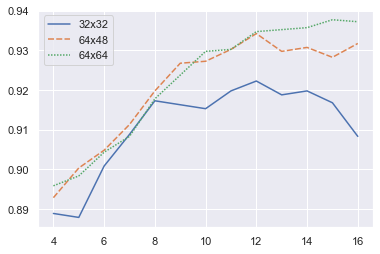

In [89]:
df= pd.DataFrame(data = {'32x32':mojalista1,'64x48':mojalista2,'64x64':mojalista3}, index = l_list) 
sns.lineplot(data = df)